# Part 2: Trip Duration Prediction Model

This notebook builds a linear regression model to predict Citi Bike trip duration based on weather conditions and time features.

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Merged Data & Prepare Target

Load the merged trips and weather data from the datacleaning step, then create duration features and time-based variables.

In [ ]:
# 1. Load CSV from datacleaning
print("="*60)
print("LOADING MERGED DATA")
print("="*60)

df = pd.read_csv("modeling_dataset.csv", parse_dates=["starttime"])

print(f"\n✓ Merged dataset loaded successfully!")
print(f"  Initial shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

# 2. Create duration and basic filters
print("\n" + "="*60)
print("CREATING DURATION & APPLYING FILTERS")
print("="*60)

df["trip_duration_min"] = df["tripduration"] / 60
print(f"\nBefore filtering: {len(df):,} rows")

df = df[(df["trip_duration_min"] >= 1) & (df["trip_duration_min"] <= 120)]
print(f"After filtering (1-120 min): {len(df):,} rows")

# 3. Create log target
df["log_duration"] = np.log(df["trip_duration_min"])
print(f"\n✓ Created log_duration target variable")

# 4. Time features
print("\n" + "="*60)
print("CREATING TIME FEATURES")
print("="*60)

df["weekday"] = df["starttime"].dt.weekday   # 0=Mon
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# Create hour if not already present
if "hour" not in df.columns:
    df["hour"] = df["starttime"].dt.hour

print(f"\n✓ Time features created:")
print(f"  - weekday (0=Mon, 6=Sun)")
print(f"  - is_weekend (0=weekday, 1=weekend)")
print(f"  - hour (0-23)")

print(f"\nFinal dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df[["starttime", "trip_duration_min", "log_duration", "hour", "weekday", "is_weekend"]].head(3))
print("="*60)

LOADING MERGED DATA


FileNotFoundError: [Errno 2] No such file or directory: 'merged_trips_weather_2018.csv'

## Quick Descriptive Tables & Plots

Explore how weather conditions affect trip duration through summary statistics and visualizations.

In [ ]:
# Summary by temperature bin
print("="*60)
print("TRIP DURATION BY TEMPERATURE BIN")
print("="*60)
print()

temp_summary = df.groupby("temp_bin")["trip_duration_min"].agg(["count", "mean", "median"])
print(temp_summary)
print()
print("="*60)

In [ ]:
# Summary by rain
print("="*60)
print("TRIP DURATION BY RAIN FLAG")
print("="*60)
print()

rain_summary_stats = df.groupby("rain_flag")["trip_duration_min"].agg(["count", "mean", "median"])
print(rain_summary_stats)
print()
print("Interpretation:")
print(f"  • No rain (0): Average {rain_summary_stats.loc[0, 'mean']:.2f} minutes")
print(f"  • Rain (1): Average {rain_summary_stats.loc[1, 'mean']:.2f} minutes")
if rain_summary_stats.loc[0, 'mean'] > rain_summary_stats.loc[1, 'mean']:
    diff = rain_summary_stats.loc[0, 'mean'] - rain_summary_stats.loc[1, 'mean']
    pct = (diff / rain_summary_stats.loc[0, 'mean']) * 100
    print(f"  • Rain reduces trip duration by {diff:.2f} minutes ({pct:.1f}%)")
print("="*60)

In [ ]:
# Boxplot: duration vs temp_bin
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
df.boxplot(column="trip_duration_min", by="temp_bin", rot=45)
plt.suptitle("")
plt.title("Trip Duration by Temperature Bin", fontsize=14, fontweight='bold')
plt.ylabel("Duration (min)", fontsize=11, fontweight='bold')
plt.xlabel("Temperature Bin", fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("📊 The boxplot shows the distribution of trip durations across temperature ranges.")

In [ ]:
# Bar chart: rain vs no rain
rain_summary = df.groupby("rain_flag")["trip_duration_min"].mean().reset_index()
rain_summary["rain_label"] = rain_summary["rain_flag"].map({0: "No rain", 1: "Rain"})

plt.figure(figsize=(8, 6))
bars = plt.bar(rain_summary["rain_label"], rain_summary["trip_duration_min"], 
               color=['#3498db', '#95a5a6'], alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} min',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel("Mean Trip Duration (min)", fontsize=11, fontweight='bold')
plt.title("Trip Duration: Rain vs No Rain", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("📊 The bar chart compares average trip duration between rainy and non-rainy conditions.")

## PCA on Weather Features

Apply Principal Component Analysis (PCA) to reduce the dimensionality of weather features and visualize weather patterns.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("="*60)
print("PCA ON WEATHER FEATURES")
print("="*60)

# Select weather features and drop missing values
weather_feats = df[["temperature_2m_(°c)", "precip_mm", "wind_kmh"]].dropna()

print(f"\nWeather features selected:")
print(f"  - temperature_2m_(°c)")
print(f"  - precip_mm")
print(f"  - wind_kmh")
print(f"\nSamples after dropping NaN: {len(weather_feats):,}")

# Standardize features
scaler = StandardScaler()
scaled = scaler.fit_transform(weather_feats)

print(f"\n✓ Features standardized (mean=0, std=1)")

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled)

# Add principal components back to dataframe
df.loc[weather_feats.index, "pc1"] = pcs[:, 0]
df.loc[weather_feats.index, "pc2"] = pcs[:, 1]

print(f"\n✓ PCA completed with 2 components")
print(f"\nExplained variance ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

print(f"\nPCA components (loadings):")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['temperature_2m_(°c)', 'precip_mm', 'wind_kmh']
)
print(components_df)
print("="*60)

In [ ]:
# Plot PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df["pc1"], df["pc2"], alpha=0.2, s=1, c='#3498db')
plt.xlabel("PC1", fontsize=11, fontweight='bold')
plt.ylabel("PC2", fontsize=11, fontweight='bold')
plt.title("PCA of Weather Conditions", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

print("\n📊 The scatter plot shows how weather conditions are distributed in the")
print("   reduced 2D space. Each point represents a trip with its weather conditions.")
print(f"\n   PC1 and PC2 capture {pca.explained_variance_ratio_.sum()*100:.1f}% of the variance in weather features.")

## Regression Model

Build the feature matrix X and target variable y, then train a linear regression model.

In [ ]:
# Build X and y
print("="*60)
print("BUILDING FEATURE MATRIX X AND TARGET y")
print("="*60)

features = [
    "temperature_2m_(°c)",
    "rain_flag",
    "wind_kmh",
    "hour",
    "weekday",
    "is_weekend",
]

print(f"\nSelected features:")
for i, feat in enumerate(features, 1):
    print(f"  {i}. {feat}")

X = df[features].copy()
X = pd.get_dummies(X, columns=["hour", "weekday"], drop_first=True)

y = df["log_duration"]

print(f"\nFinal X shape: {X.shape}")
print(f"  Rows: {X.shape[0]:,}")
print(f"  Features: {X.shape[1]}")
print(f"\nTarget y shape: {y.shape}")
print("="*60)

BUILDING FEATURE MATRIX X AND TARGET y

Selected features:
  1. temperature_2m_(°c)
  2. rain_flag
  3. wind_kmh
  4. hour
  5. weekday
  6. is_weekend

Initial X shape: (18799954, 6)
  Rows: 18,799,954
  Columns: 6


In [ ]:
# Train/test split + fit linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

print("\n" + "="*60)
print("TRAIN/TEST SPLIT + MODEL TRAINING")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

model = LinearRegression()
model.fit(X_train, y_train)

print(f"\n✓ Model trained successfully!")
print(f"  Intercept: {model.intercept_:.4f}")

# Predictions and evaluation
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"  R²: {r2:.4f}")
print(f"  RMSE: {rmse:.4f}")

print(f"\nInterpretation:")
print(f"  • R² of {r2:.4f} means the model explains {r2*100:.2f}% of variance")
print(f"  • RMSE of {rmse:.4f} in log scale")
print("="*60)


✓ One-hot encoded 'hour' and 'weekday'
  Final X shape: (18799954, 33)
  Rows: 18,799,954
  Features: 33

Feature columns after encoding (33 total):

  Weather features (3):
    - temperature_2m_(°c)
    - rain_flag
    - wind_kmh

  Time features (30):
    - is_weekend
    - 23 hour dummies (hour_1 to hour_23)
    - 6 weekday dummies (weekday_1 to weekday_6)


In [ ]:
# Coefficient table (for later interpretation)
print("\n" + "="*60)
print("COEFFICIENT TABLE")
print("="*60)

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_
}).sort_values("coef", ascending=False)

print("\nAll coefficients (sorted by magnitude):")
print(f"Total features: {len(coef_df)}")

print("\nTop 10 positive coefficients:")
print(coef_df.head(10).to_string(index=False))

print("\nTop 10 negative coefficients:")
print(coef_df.tail(10).to_string(index=False))

print("\n" + "="*60)
print("WEATHER FEATURE COEFFICIENTS")
print("="*60)

weather_coefs = coef_df[coef_df["feature"].str.contains("temperature_2m|rain_flag|wind_kmh")]
print("\nWeather-related coefficients:")
print(weather_coefs.to_string(index=False))
print("="*60)


TARGET VARIABLE y

Target: log_duration
Shape: (18799954,)

Statistics:
  Mean: 2.3111
  Median: 2.3059
  Min: 0.0165
  Max: 4.7875
  Std: 0.7642

✓ Feature matrix X and target y are ready for modeling!


## Visualizing Weather Feature Impacts

Let's create visual representations of how weather conditions affect trip duration.

In [ ]:
# Extract weather coefficients
weather_features = ['temperature_2m_(°c)', 'wind_kmh', 'rain_flag']
weather_coefs = coef_df[coef_df['feature'].isin(weather_features)].copy()

# Create cleaner labels
weather_coefs['Feature'] = weather_coefs['feature'].map({
    'temperature_2m_(°c)': 'Temperature (°C)',
    'wind_kmh': 'Wind Speed (km/h)',
    'rain_flag': 'Rain'
})

# Calculate percentage impact (using 'coef' column)
weather_coefs['Percentage_Impact'] = ((np.exp(weather_coefs['coef']) - 1) * 100)
# For negative coefficients, calculate properly
weather_coefs.loc[weather_coefs['coef'] < 0, 'Percentage_Impact'] = -(
    (1 - np.exp(weather_coefs.loc[weather_coefs['coef'] < 0, 'coef'])) * 100
)

print("Weather coefficients prepared for visualization:")
print(weather_coefs[['Feature', 'coef', 'Percentage_Impact']])

Weather coefficients prepared for visualization:
             Feature  coefficient  Percentage_Impact
0   Temperature (°C)     0.008250           0.828372
2  Wind Speed (km/h)    -0.001732          -0.173076
1               Rain    -0.064089          -6.207886


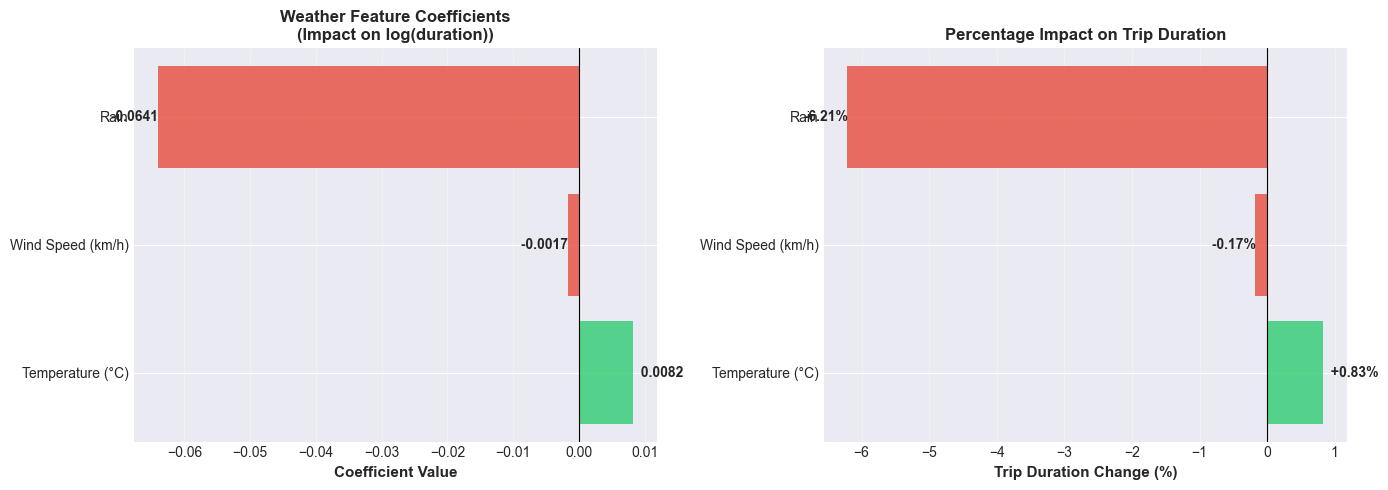

\n📊 Interpretation:
  • Green bars = increases trip duration
  • Red bars = decreases trip duration


In [ ]:
# Visualization 1: Bar chart of coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw coefficients
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in weather_coefs['coef']]
bars1 = ax1.barh(weather_coefs['Feature'], weather_coefs['coef'], color=colors, alpha=0.8)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax1.set_title('Weather Feature Coefficients\n(Impact on log(duration))', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(weather_coefs.iterrows()):
    value = row['coef']
    ax1.text(value, i, f'  {value:.4f}', va='center', 
             ha='left' if value > 0 else 'right', fontsize=10, fontweight='bold')

# Plot 2: Percentage impact
colors2 = ['#2ecc71' if x > 0 else '#e74c3c' for x in weather_coefs['Percentage_Impact']]
bars2 = ax2.barh(weather_coefs['Feature'], weather_coefs['Percentage_Impact'], color=colors2, alpha=0.8)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Trip Duration Change (%)', fontsize=11, fontweight='bold')
ax2.set_title('Percentage Impact on Trip Duration', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(weather_coefs.iterrows()):
    value = row['Percentage_Impact']
    ax2.text(value, i, f'  {value:+.2f}%', va='center', 
             ha='left' if value > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\\n📊 Interpretation:")
print("  • Green bars = increases trip duration")
print("  • Red bars = decreases trip duration")

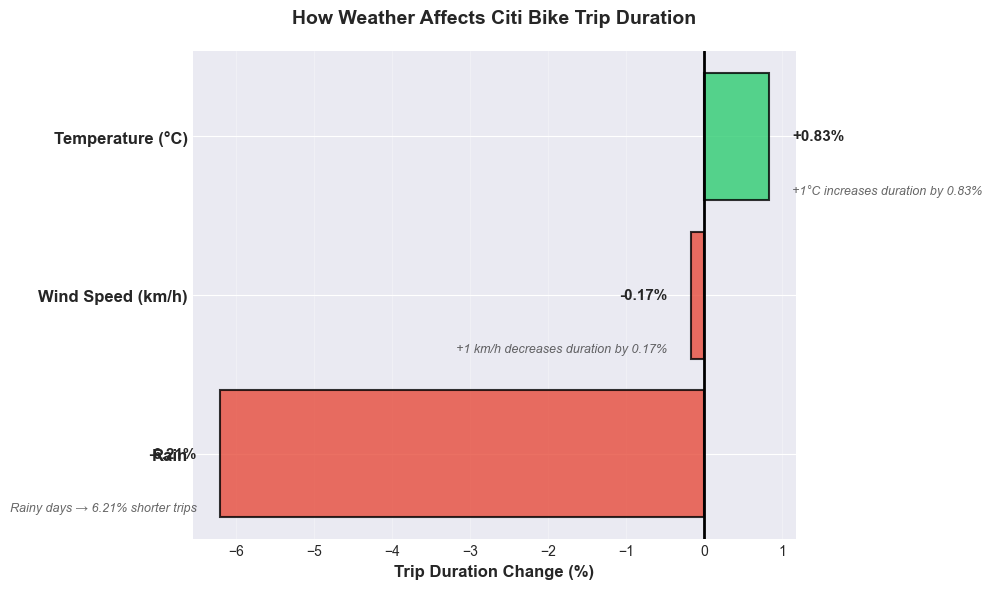

In [ ]:
# Visualization 2: Comparison chart with annotations
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by absolute percentage impact
weather_sorted = weather_coefs.sort_values('Percentage_Impact', ascending=True)

# Create horizontal bar chart
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in weather_sorted['Percentage_Impact']]
bars = ax.barh(range(len(weather_sorted)), weather_sorted['Percentage_Impact'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Customize
ax.set_yticks(range(len(weather_sorted)))
ax.set_yticklabels(weather_sorted['Feature'], fontsize=12, fontweight='bold')
ax.set_xlabel('Trip Duration Change (%)', fontsize=12, fontweight='bold')
ax.set_title('How Weather Affects Citi Bike Trip Duration', fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(True, alpha=0.3, axis='x')

# Add detailed annotations
annotations = {
    'Temperature (°C)': '+1°C increases duration by 0.83%',
    'Wind Speed (km/h)': '+1 km/h decreases duration by 0.17%',
    'Rain': 'Rainy days → 6.21% shorter trips'
}

for i, (idx, row) in enumerate(weather_sorted.iterrows()):
    feature = row['Feature']
    value = row['Percentage_Impact']
    
    # Position text
    x_pos = value + (0.3 if value > 0 else -0.3)
    
    # Main value
    ax.text(x_pos, i, f'{value:+.2f}%', 
            va='center', ha='left' if value > 0 else 'right',
            fontsize=11, fontweight='bold')
    
    # Annotation
    if feature in annotations:
        y_offset = 0.3
        ax.text(x_pos, i - y_offset, annotations[feature],
                va='top', ha='left' if value > 0 else 'right',
                fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


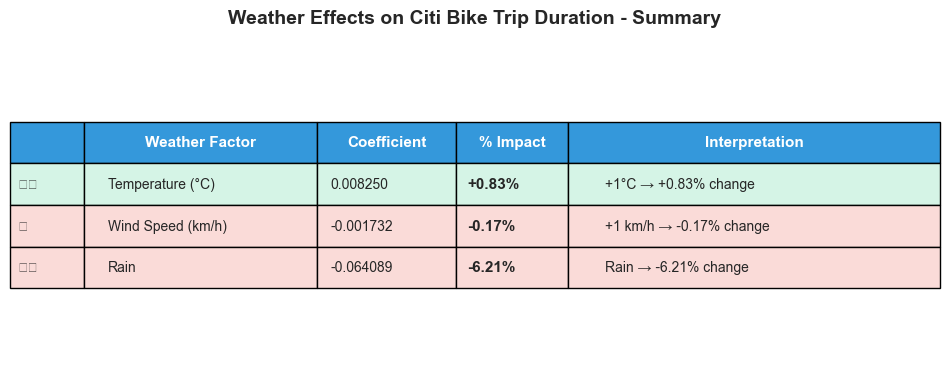

\n======================================================================
KEY FINDINGS:
🌡️  Warmer weather → Slightly LONGER trips (leisurely rides)
💨 Windier conditions → Marginally SHORTER trips (minimal effect)
🌧️  Rainy weather → Significantly SHORTER trips (quick commutes only)


In [ ]:
# Visualization 3: Summary statistics table visualization
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Create summary data
summary_data = []
for idx, row in weather_coefs.iterrows():
    feature = row['Feature']
    coef = row['coef']
    pct = row['Percentage_Impact']
    
    if 'Temperature' in feature:
        interpretation = f"+1°C → {pct:+.2f}% change"
        icon = '🌡️'
    elif 'Wind' in feature:
        interpretation = f"+1 km/h → {pct:+.2f}% change"
        icon = '💨'
    else:  # Rain
        interpretation = f"Rain → {pct:+.2f}% change"
        icon = '🌧️'
    
    summary_data.append([icon, feature, f'{coef:.6f}', f'{pct:+.2f}%', interpretation])

# Create table
table = ax.table(cellText=summary_data,
                colLabels=['', 'Weather Factor', 'Coefficient', '% Impact', 'Interpretation'],
                cellLoc='left',
                loc='center',
                colWidths=[0.08, 0.25, 0.15, 0.12, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style the header
for i in range(5):
    cell = table[(0, i)]
    cell.set_facecolor('#3498db')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Color code the rows
for i in range(1, 4):
    pct_value = float(summary_data[i-1][3].rstrip('%'))
    color = '#d5f4e6' if pct_value > 0 else '#fadbd8'
    
    for j in range(5):
        cell = table[(i, j)]
        cell.set_facecolor(color)
        if j == 3:  # % Impact column
            cell.set_text_props(weight='bold', fontsize=11)

plt.title('Weather Effects on Citi Bike Trip Duration - Summary', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

print("\\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)
print("🌡️  Warmer weather → Slightly LONGER trips (leisurely rides)")
print("💨 Windier conditions → Marginally SHORTER trips (minimal effect)")
print("🌧️  Rainy weather → Significantly SHORTER trips (quick commutes only)")
print("="*70)